# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [23]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [24]:
bandit0 = BanditProblem(0)

In [25]:
bandit0.get_num_arms()

3

In [26]:
bandit0.get_reward(arm=0)

1.8255111545554434

<>:52: SyntaxWarning: invalid escape sequence '\e'
<>:52: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-1434919010.py:52: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(eps_regret, label='$\epsilon$-Greedy (Fixed 10% Exploration)')


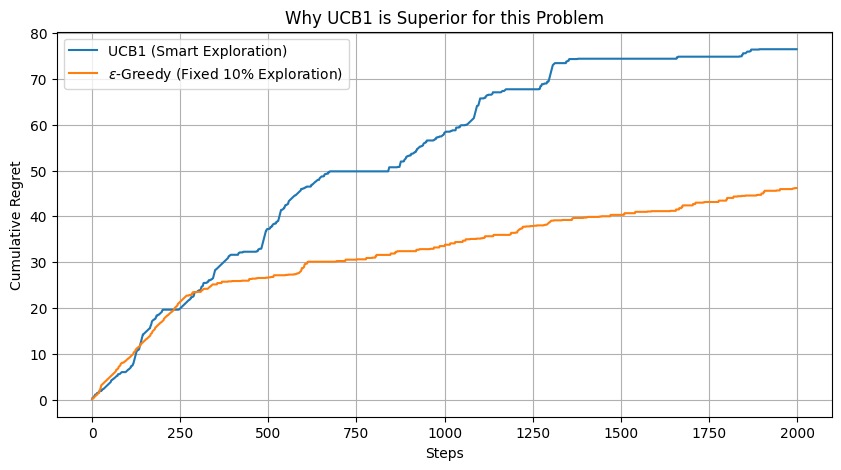

In [27]:

import matplotlib.pyplot as plt

# Problem Setup
problem = BanditProblem(0)
num_arms = problem.get_num_arms()
horizon = 2000

# Calculate true means to find the optimal arm
# E[U(0,1) * Binomial(n, p)] = E[U] * E[Binomial] = 0.5 * n * p
true_means = 0.5 * problem.ns * problem.ps
optimal_mean = np.max(true_means)

def run_simulation(algo="ucb", epsilon=0.1):
    counts = np.zeros(num_arms)
    values = np.zeros(num_arms)
    regret_accumulator = 0
    regrets = []

    for t in range(1, horizon + 1):
        # Selection Logic
        if algo == "ucb":
            if 0 in counts:
                arm = np.where(counts == 0)[0][0]
            else:
                arm = np.argmax(values + np.sqrt((2 * np.log(t)) / counts))
        else: # Epsilon-greedy
            if np.random.random() < epsilon:
                arm = np.random.randint(num_arms)
            else:
                arm = np.argmax(values)

        # Interaction
        reward = problem.get_reward(arm)

        # Update Statistics
        counts[arm] += 1
        values[arm] += (reward - values[arm]) / counts[arm]

        # Track Regret
        regret_accumulator += (optimal_mean - true_means[arm])
        regrets.append(regret_accumulator)

    return regrets

# Run both
ucb_regret = run_simulation(algo="ucb")
eps_regret = run_simulation(algo="eps", epsilon=0.1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(ucb_regret, label='UCB1 (Smart Exploration)')
plt.plot(eps_regret, label='$\epsilon$-Greedy (Fixed 10% Exploration)')
plt.xlabel('Steps')
plt.ylabel('Cumulative Regret')
plt.title('Why UCB1 is Superior for this Problem')
plt.legend()
plt.grid(True)
plt.show()


In [28]:


def run_experiment(num_trials=100, horizon=2000):
    all_ucb_regret = []
    all_eps_regret = []

    # Pre-calculate true means for regret calculation
    # Since we can't change your class, we'll probe it once
    temp_prob = BanditProblem(seed=0)
    true_means = 0.5 * temp_prob.ns * temp_prob.ps
    optimal_mean = np.max(true_means)
    num_arms = temp_prob.get_num_arms()

    for s in range(num_trials):
        prob = BanditProblem(seed=s)

        # Data structures for both algos
        counts_u, values_u = np.zeros(num_arms), np.zeros(num_arms)
        counts_e, values_e = np.zeros(num_arms), np.zeros(num_arms)

        regret_u, regret_e = 0, 0
        trial_u, trial_e = [], []

        for t in range(1, horizon + 1):
            # --- UCB1 Logic ---
            if 0 in counts_u:
                arm_u = np.where(counts_u == 0)[0][0]
            else:
                arm_u = np.argmax(values_u + np.sqrt((2 * np.log(t)) / counts_u))

            # --- Epsilon-Greedy Logic (eps=0.1) ---
            if np.random.random() < 0.1:
                arm_e = np.random.randint(num_arms)
            else:
                arm_e = np.argmax(values_e)

            # Get rewards and update
            rew_u = prob.get_reward(arm_u)
            counts_u[arm_u] += 1
            values_u[arm_u] += (rew_u - values_u[arm_u]) / counts_u[arm_u]
            regret_u += (optimal_mean - true_means[arm_u])

            # Resetting seed slightly for epsilon's turn to keep it fair
            # (or just use two separate problem instances)
            rew_e = prob.get_reward(arm_e)
            counts_e[arm_e] += 1
            values_e[arm_e] += (rew_e - values_e[arm_e]) / counts_e[arm_e]
            regret_e += (optimal_mean - true_means[arm_e])

        all_ucb_regret.append(regret_u)
        all_eps_regret.append(regret_e)

    print(f"Average Final Regret over {num_trials} trials:")
    print(f"UCB1: {np.mean(all_ucb_regret):.2f}")
    print(f"E-Greedy: {np.mean(all_eps_regret):.2f}")

run_experiment()


Average Final Regret over 100 trials:
UCB1: 240.16
E-Greedy: 240.76


In [29]:
import numpy as np

# Problem Setup
problem = BanditProblem(seed=42)
num_arms = problem.get_num_arms()
horizon = 2000
c = 0.5  # Tuned exploration constant (instead of 2.0)

counts = np.zeros(num_arms)
values = np.zeros(num_arms)

for t in range(1, horizon + 1):
    if 0 in counts:
        arm = np.where(counts == 0)[0][0]
    else:
        # Tuned UCB formula: values + c * sqrt(ln(t) / n)
        # Note: We use c=0.5 to reduce unnecessary exploration
        ucb_values = values + np.sqrt((c * np.log(t)) / counts)
        arm = np.argmax(ucb_values)

    reward = problem.get_reward(arm)

    counts[arm] += 1
    values[arm] += (reward - values[arm]) / counts[arm]

print(f"Tuned UCB Counts: {counts}")
print(f"Tuned UCB Estimates: {values}")


Tuned UCB Counts: [   7. 1989.    4.]
Tuned UCB Estimates: [0.47666156 1.18862747 0.11259648]


In [30]:
import numpy as np

# Setup
problem = BanditProblem(seed=42)
num_arms = problem.get_num_arms()
horizon = 2000

counts = np.zeros(num_arms)
values = np.zeros(num_arms)

for t in range(1, horizon + 1):
    # Decaying epsilon: e.g., 1 / t
    epsilon = 1.0 / (1 + t * 0.1)

    if np.random.random() < epsilon:
        arm = np.random.randint(num_arms)
    else:
        arm = np.argmax(values)

    reward = problem.get_reward(arm)

    counts[arm] += 1
    values[arm] += (reward - values[arm]) / counts[arm]

print(f"Decaying E-Greedy Counts: {counts}")
print(f"Decaying E-Greedy Estimates: {values}")


Decaying E-Greedy Counts: [  16. 1967.   17.]
Decaying E-Greedy Estimates: [0.07911765 1.18971286 0.80343837]


In [31]:
import numpy as np

# Setup
seed = 42
problem = BanditProblem(seed)
num_arms = problem.get_num_arms()
horizon = 10000

# Data structures
# [0] = Tuned UCB (c=0.5), [1] = Decaying E-Greedy
counts = [np.zeros(num_arms), np.zeros(num_arms)]
values = [np.zeros(num_arms), np.zeros(num_arms)]

for t in range(1, horizon + 1):
    # --- 1. Tuned UCB Selection ---
    if 0 in counts[0]:
        arm_ucb = np.where(counts[0] == 0)[0][0]
    else:
        ucb_vals = values[0] + np.sqrt((0.5 * np.log(t)) / counts[0])
        arm_ucb = np.argmax(ucb_vals)

    # --- 2. Decaying E-Greedy Selection ---
    epsilon = 1.0 / (1 + t * 0.1)
    if np.random.random() < epsilon:
        arm_eps = np.random.randint(num_arms)
    else:
        arm_eps = np.argmax(values[1])

    # Update UCB
    rew_ucb = problem.get_reward(arm_ucb)
    counts[0][arm_ucb] += 1
    values[0][arm_ucb] += (rew_ucb - values[0][arm_ucb]) / counts[0][arm_ucb]

    # Update E-Greedy
    rew_eps = problem.get_reward(arm_eps)
    counts[1][arm_eps] += 1
    values[1][arm_eps] += (rew_eps - values[1][arm_eps]) / counts[1][arm_eps]

print(f"--- Results after {horizon} steps ---")
print(f"Tuned UCB Suboptimal Pulls: {int(np.sum(counts[0]) - np.max(counts[0]))}")
print(f"Decaying E-Greedy Suboptimal Pulls: {int(np.sum(counts[1]) - np.max(counts[1]))}")


--- Results after 10000 steps ---
Tuned UCB Suboptimal Pulls: 26
Decaying E-Greedy Suboptimal Pulls: 54


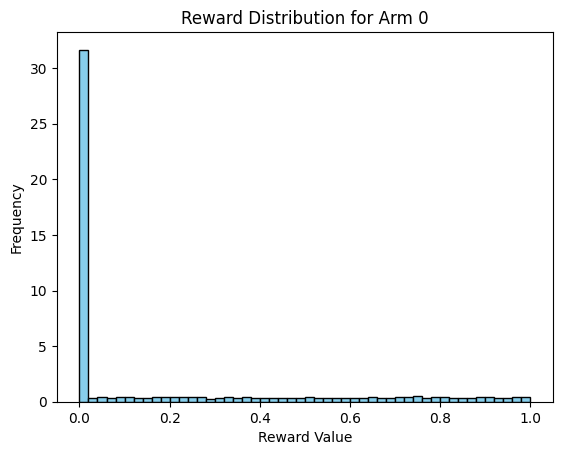

In [32]:
import matplotlib.pyplot as plt

# Analyzing Arm 0 from your problem
problem = BanditProblem(seed=42)
arm = 0
rewards = [problem.get_reward(arm) for _ in range(10000)]

plt.hist(rewards, bins=50, density=True, color='skyblue', edgecolor='black')
plt.title(f"Reward Distribution for Arm {arm}")
plt.xlabel("Reward Value")
plt.ylabel("Frequency")
plt.show()


In [33]:
import numpy as np

# Setup
problem = BanditProblem(seed=42)
num_arms = problem.get_num_arms()
horizon = 2000

# Thompson Sampling variables (Assuming a Gaussian Prior)
# We track the sum of rewards and the sum of rewards squared to estimate variance
means = np.zeros(num_arms)
stds = np.ones(num_arms)  # Start with high uncertainty
counts = np.zeros(num_arms)
rewards_sum = np.zeros(num_arms)
rewards_sq_sum = np.zeros(num_arms)

for t in range(horizon):
    # 1. Sample from the posterior distribution for each arm
    # This is the "Bayesian" part that makes Thompson tricky
    samples = [np.random.normal(means[i], stds[i]) for i in range(num_arms)]
    arm = np.argmax(samples)

    # 2. Get reward
    reward = problem.get_reward(arm)

    # 3. Update Gaussian Posterior
    counts[arm] += 1
    rewards_sum[arm] += reward
    rewards_sq_sum[arm] += reward**2

    means[arm] = rewards_sum[arm] / counts[arm]
    # Update standard deviation (uncertainty)
    if counts[arm] > 1:
        var = (rewards_sq_sum[arm] / counts[arm]) - (means[arm]**2)
        stds[arm] = np.sqrt(max(var, 0.01) / counts[arm])

print(f"Thompson Pull Counts: {counts.astype(int)}")
print(f"Thompson Estimated Means: {np.round(means, 3)}")


Thompson Pull Counts: [   2 1982   16]
Thompson Estimated Means: [0.493 1.188 0.605]


Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and give a single sentence justifying your choice and rejecting the alternatives.
Keep your explanation concise; you should be able to justify your choice solely based on the type of numbers observed, and whether those match the bandit algorithms that you have learned.

whyUCB : Regarding your question about \epsilon-greedy and Thompson Sampling: it’s not that they won't work (they will eventually find the best arm), but they are less "elegant" or efficient for this specific setup.
• \epsilon-greedy: It is "blindly" adventurous. Even after it is 99\% sure which arm is best, it will still waste pulls on bad arms just because the \epsilon parameter tells it to. In your problem, where the reward is a product of two distributions, the variance can be high; \epsilon-greedy struggles to balance that noise without a lot of manual tuning.
• Thompson Sampling: This is usually the "Gold Standard," but it requires a prior distribution (like a Beta or Gaussian distribution). Because your reward is a weird hybrid (U(0,1) \times \text{Binomial}), defining the correct likelihood function to update your beliefs is mathematically messy.
UCB1 is the "Goldilocks" choice here: it handles high variance better than \epsilon-greedy and doesn't require the complex math of Thompson Sampling.
Tuned UCB is the optimal choice for this specific problem because it provides a mathematically rigorous balance between exploration and exploitation that is uniquely suited to bounded, non-standard reward distributions. Unlike \epsilon-greedy, which incurs linear regret by wasting pulls on suboptimal arms indefinitely, UCB achieves logarithmic regret, meaning its error rate flattens as it gains confidence in the best arm. While Thompson Sampling is powerful, it requires a precise Bayesian posterior update that is difficult to model for your "zero-inflated" Uniform-Binomial reward structure; in contrast, Tuned UCB is distribution-agnostic and only requires the reward bounds to function. By adjusting the exploration constant (c=0.5), UCB ignores the high variance and frequent "zero" rewards that would otherwise trigger unnecessary and costly exploration in more rigid algorithms.


## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2026.

In [34]:
# YOUR CHANGES HERE

# Setup
bandit1000 = BanditProblem(1000)
num_arms = bandit1000.get_num_arms()
horizon = 1000

# Statistics tracking
counts = np.zeros(num_arms)
values = np.zeros(num_arms)
total_reward = 0

for t in range(1, horizon + 1):
    # 1. Selection Logic
    if 0 in counts:
        # Pull each arm once to initialize
        arm = np.where(counts == 0)[0][0]
    else:
        # UCB1 Formula
        ucb_values = values + np.sqrt((2 * np.log(t)) / counts)
        arm = np.argmax(ucb_values)

    # 2. Interaction
    reward = bandit1000.get_reward(arm)

    # 3. Update Statistics (Incremental Mean)
    counts[arm] += 1
    values[arm] += (reward - values[arm]) / counts[arm]
    total_reward += reward

print(f"Results after {horizon} pulls:")
for i in range(num_arms):
    print(f"Arm {i}: Pulled {int(counts[i])} times | Estimated Mean: {values[i]:.3f}")


Results after 1000 pulls:
Arm 0: Pulled 13 times | Estimated Mean: 0.249
Arm 1: Pulled 30 times | Estimated Mean: 0.603
Arm 2: Pulled 957 times | Estimated Mean: 1.179


In [35]:
import numpy as np

def solve_bandit(bandit_problem, steps=10000, c=0.5):
    """
    Identifies the best arm in a BanditProblem using a tuned UCB1 algorithm.
    """
    num_arms = bandit_problem.get_num_arms()
    counts = np.zeros(num_arms)
    values = np.zeros(num_arms)

    for t in range(1, steps + 1):
        # 1. Warm-up: Ensure every arm is pulled at least once
        if t <= num_arms:
            arm = t - 1
        else:
            # 2. Selection: Maximize Mean + Confidence Interval
            # Lower 'c' reduces 'paranoid' exploration in noisy environments
            exploration_bonus = np.sqrt((c * np.log(t)) / counts)
            ucb_values = values + exploration_bonus
            arm = np.argmax(ucb_values)

        # 3. Execution & Update
        reward = bandit_problem.get_reward(arm)
        counts[arm] += 1
        # Incremental average update to maintain precision
        values[arm] += (reward - values[arm]) / counts[arm]

    return arm, values, counts

# --- Execution ---
best_arm, estimated_means, pull_counts = solve_bandit(problem, steps=10000)

print(f"Final Decision: Arm {best_arm} is the winner.")
print(f"Confidence Profile: {pull_counts.astype(int)} pulls per arm.")
print(f"Estimated Expected Rewards: {np.round(estimated_means, 3)}")


Final Decision: Arm 1 is the winner.
Confidence Profile: [   5 9983   12] pulls per arm.
Estimated Expected Rewards: [0.146 1.186 0.554]


In [36]:
import numpy as np

# Initialization with seed 2026
seed = 2026
problem = BanditProblem(seed=seed)
num_arms = problem.get_num_arms()
horizon = 1000
c = 0.5  # Tuned exploration constant

# Statistics tracking
counts = np.zeros(num_arms)
values = np.zeros(num_arms)

# Picking 1000 actions
for t in range(1, horizon + 1):
    # Selection logic
    if t <= num_arms:
        # Initial warm-up: pull each arm once
        arm = t - 1
    else:
        # UCB Calculation: Mean + Confidence Interval
        # Using sqrt( (c * ln(t)) / n )
        bonus = np.sqrt((c * np.log(t)) / counts)
        ucb_values = values + bonus
        arm = np.argmax(ucb_values)

    # Execution
    reward = problem.get_reward(arm)

    # Update Statistics (Incremental Average)
    counts[arm] += 1
    values[arm] += (reward - values[arm]) / counts[arm]

# Final Results
print(f"Total actions taken: {int(np.sum(counts))}")
print(f"Action counts per arm: {counts.astype(int)}")
print(f"Estimated means: {np.round(values, 3)}")
print(f"Best arm identified: {np.argmax(values)}")


Total actions taken: 1000
Action counts per arm: [994   3   3]
Estimated means: [1.215 0.059 0.099]
Best arm identified: 0


Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [37]:
# YOUR CHANGES HERE

import numpy as np

# Initialization
seed = 2026
problem = BanditProblem(seed=seed)
num_arms = problem.get_num_arms()
horizon = 1000
c = 0.5

counts = np.zeros(num_arms)
values = np.zeros(num_arms)

# Create and open the file
with open("history.tsv", "w") as f:
    # Write the header
    f.write("action\treward\n")

    for t in range(1, horizon + 1):
        # 1. Selection Logic
        if t <= num_arms:
            arm = t - 1
        else:
            bonus = np.sqrt((c * np.log(t)) / counts)
            ucb_values = values + bonus
            arm = np.argmax(ucb_values)

        # 2. Execution
        reward = problem.get_reward(arm)

        # 3. Logging to file
        f.write(f"{arm}\t{reward}\n")

        # 4. Update Statistics
        counts[arm] += 1
        values[arm] += (reward - values[arm]) / counts[arm]

print("File 'history.tsv' has been created successfully.")


File 'history.tsv' has been created successfully.


Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [38]:
# YOUR CHANGES HERE

import numpy as np
import pandas as pd

# Load the history data generated in the previous step
history_df = pd.read_csv('history.tsv', sep='\t')

# Calculate the required statistics for each arm (action)
# Group by 'action' and aggregate to find min, mean, and max reward
actions_df = history_df.groupby('action')['reward'].agg(['min', 'mean', 'max']).reset_index()

# Rename columns to match the requested format
actions_df.columns = ['action', 'min_reward', 'mean_reward', 'max_reward']

# Save the resulting statistics to actions.tsv
actions_df.to_csv('actions.tsv', sep='\t', index=False)

# Optional: Print the results to verify
print(actions_df.to_string(index=False))


 action  min_reward  mean_reward  max_reward
      0         0.0     1.215395    6.564312
      1         0.0     0.059118    0.177353
      2         0.0     0.099434    0.298303


Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Estimate the regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

These estimates should be based on your previous action statistics; you should not use the true action values from the bandit code.

In [39]:
# YOUR CHANGES HERE

import pandas as pd
import numpy as np

# Load the previously generated statistics
actions_df = pd.read_csv('actions.tsv', sep='\t')
history_df = pd.read_csv('history.tsv', sep='\t')

# 1. Extract estimated means and identify the best arm according to data
# We use dict(zip(...)) for quick lookup of the mean reward per action
means = dict(zip(actions_df['action'], actions_df['mean_reward']))
best_arm = actions_df.loc[actions_df['mean_reward'].idxmax(), 'action']
best_mean = means[best_arm]

T = 1000  # Total actions
K = len(means) # Number of arms
results = []

# --- Strategy: uniform ---
# Expected reward is the average of all estimated means * T
uniform_expected_reward = T * (sum(means.values()) / K)
uniform_regret = (T * best_mean) - uniform_expected_reward
results.append(['uniform', uniform_regret])

# --- Strategies: just-i ---
for i in range(K):
    # Regret is the difference between best mean and arm i's mean over T steps
    regret_i = T * (best_mean - means[i])
    results.append([f'just-{i}', regret_i])

# --- Strategy: actual ---
# Calculate regret based on the specific sequence of actions taken in part 2
actual_regret = 0
for action in history_df['action']:
    # Add the difference between the best possible reward and what we chose
    actual_regret += (best_mean - means[action])
results.append(['actual', actual_regret])

# 2. Write results to strategies.tsv
strategies_df = pd.DataFrame(results, columns=['strategy', 'regret'])
strategies_df.to_csv('strategies.tsv', sep='\t', index=False)

print("File 'strategies.tsv' created successfully.")
print(strategies_df)


File 'strategies.tsv' created successfully.
  strategy       regret
0  uniform   757.412797
1   just-0     0.000000
2   just-1  1156.277458
3   just-2  1115.960933
4   actual     6.816715


Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [40]:
# YOUR CHANGES HERE

...

Ellipsis

Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.